# Dataset de Estrellas ⭐
**El dataset contiene las siguientes columnas:**

* Temperature (K): Temperatura de la estrella en Kelvin.
* Luminosity (L/Lo): Luminosidad en relación al Sol.
* Radius (R/Ro): Radio en relación al Sol.
* Absolute magnitude (Mv): Magnitud absoluta de la estrella.
* Star type: Tipo de estrella (Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence, SuperGiants, HyperGiants).
  * Brown Dwarf -> Star Type = 0
  * Red Dwarf -> Star Type = 1
  * White Dwarf-> Star Type = 2
  * Main Sequence -> Star Type = 3
  * Supergiant -> Star Type = 4
  *Hypergiant -> Star Type = 5
* Star color: Color de la estrella (white, Red, Blue, Yellow, yellow-orange, etc.).
* Spectral Class: Clasificación espectral (O,B,A,F,G,K,,M).

In [2]:
import pandas as pd
import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

## Exploración de los Datos

In [ ]:
# Leemos el dataset:
path = kagglehub.dataset_download("deepu1109/star-dataset")
file_path = os.path.join(path, "6 class csv.csv")
data = pd.read_csv(file_path)

# Primeras filas de los datos:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


In [ ]:
# Resumen estadístico de los datos:
data.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [ ]:
import plotly.express as px

fig = px.scatter(data,
                 x="Star type", y='Absolute magnitude(Mv)', size="Radius(R/Ro)", color="Temperature (K)",
                 log_x=True, size_max=60,
                 template='plotly_dark', title='Star Type vs Absolute Magnitude')
fig.show()

In [ ]:
fig = px.density_heatmap(data, x="Radius(R/Ro)", y="Luminosity(L/Lo)", title='Radius vs Luminosity', template='plotly_dark')
fig.show()


In [ ]:
fig = px.density_heatmap(data, x="Temperature (K)", y="Absolute magnitude(Mv)", title='Temperature vs Absolute Magnitude', template='plotly_dark')
fig.show()


In [ ]:
fig = px.scatter_ternary(data,
                         a="Absolute magnitude(Mv)", b="Luminosity(L/Lo)", c="Radius(R/Ro)",
                         hover_name="Star type", color="Temperature (K)",
                         template='plotly_dark', size="Temperature (K)", size_max=30)
fig.show()

In [ ]:
fig = px.scatter_3d(data,
                    x='Star type', y='Absolute magnitude(Mv)', z='Spectral Class',
                    color='Temperature (K)', template='plotly_dark',
                    title='Star Type vs Spectral Class and Magnitude')
fig.show()

In [ ]:
fig = px.box(data, x="Star type", y="Temperature (K)", template='plotly_white',
             title='Boxplot: Star Type vs Temperature')
fig.show()

In [ ]:
fig = px.pie(data, names='Spectral Class', values='Temperature (K)', template='plotly_dark',
             title='Pie Chart: Spectral Class vs Temperature')
fig.show()

## Preprocesamiento de los Datos

In [ ]:
data.isnull().sum()

,0
Temperature (K),0
Luminosity(L/Lo),0
Radius(R/Ro),0
Absolute magnitude(Mv),0
Star type,0
Star color,0
Spectral Class,0


Con esto sabemos que no hay valores nulos en el dataset. Las variables **categóricas** son `Star color` y `Spectral Class`, mientras que las demás son **numéricas**.

In [ ]:
data['Star color'] = data['Star color'].astype('category').cat.codes
data['Spectral Class'] = data['Spectral Class'].astype('category').cat.codes

data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,10,5
1,3042,0.000500,0.1542,16.60,0,10,5
2,2600,0.000300,0.1020,18.70,0,10,5
3,2800,0.000200,0.1600,16.65,0,10,5
4,1939,0.000138,0.1030,20.06,0,10,5


Las características numéricas (`Temperature`, `Luminosity`, `Radius`, `Absolute magnitude`) tienen diferentes rangos. Por ejemplo:

* `Temperature` puede variar entre 2000 y 40000 Kelvin.
* `Luminosity` puede variar entre 0.0001 y 800000 veces la luminosidad del Sol.

Esto significa que una característica con un rango grande (como `Luminosity`) podría dominar las otras características durante el cálculo de distancias, sesgando los resultados del clustering.

Para evitar esto, escalamos las características para que todas tengan media 0 y desviación estándar 1:

In [ ]:
# Seleccionar solo las características numéricas:
features = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

# Escalar las características:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

# Convertir a DataFrame para mejor visualización:
scaled_data = pd.DataFrame(scaled_features, columns=features)
scaled_data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
0,-0.779382,-0.598624,-0.459210,1.116745
1,-0.782110,-0.598624,-0.459241,1.162414
2,-0.828477,-0.598624,-0.459342,1.362213
3,-0.807496,-0.598624,-0.459229,1.167171
4,-0.897819,-0.598624,-0.459340,1.491607


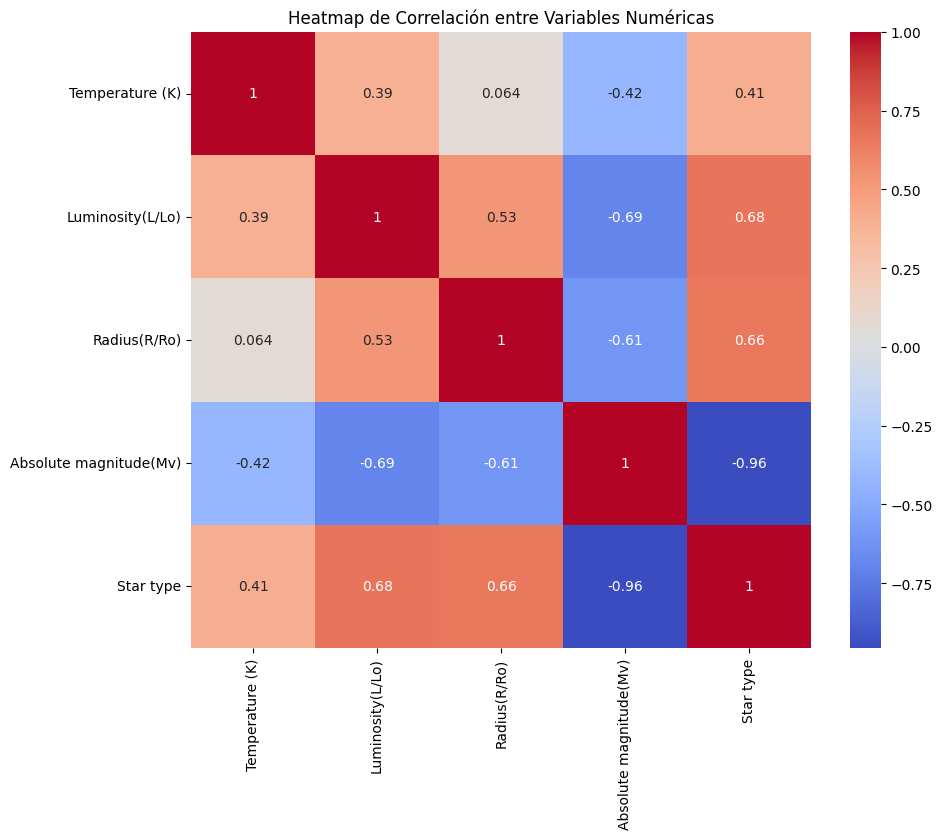

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Heatmap de Correlación entre Variables Numéricas')
plt.show()

## Determinar el Número Óptimo de Clusters

K-Means requiere especificar el número de clusters (`k`) de antemano. Para determinar el número óptimo de clusters en el dataset, utilizamos el **método del codo**, que nos permite evaluar cómo la inercia disminuye a medida que aumentamos el número de clusters (`k`). La idea detrás de este método es identificar un punto de "inflexión" en la curva de inercia, donde agregar más clusters deja de reducir significativamente la inercia.

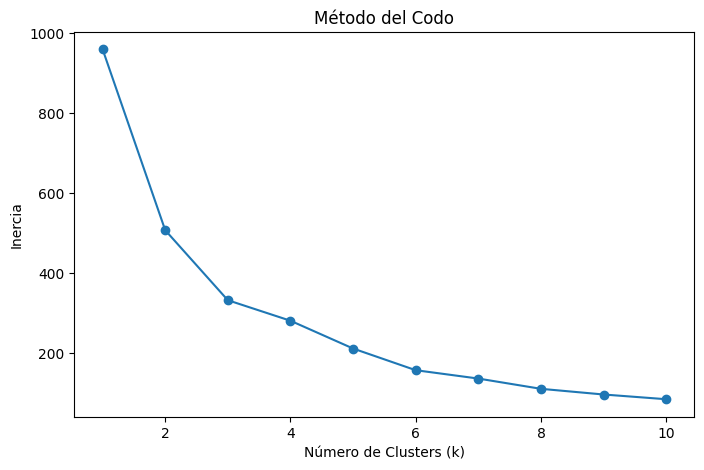

In [ ]:
# Calcular la inercia para diferentes valores de k:
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.show()

La inercia mide qué tan "compactos" son los clusters. A medida que aumentamos `k`, la inercia disminuye porque los puntos están más cerca de sus centroides.
El "codo" en el gráfico indica el punto donde agregar más clusters ya no mejora significativamente la compactación. Este es un buen indicador del número óptimo de clusters.

### Interpretación Visual del Método del Codo
Al graficar la inercia frente al número de clusters, observamos lo siguiente:

* Para valores pequeños de `k` (por ejemplo, `k=2` o `k=3`), la inercia disminuye rápidamente. Esto indica que agregar más clusters mejora significativamente la agrupación de las estrellas.
* A partir de `k=5`, la curva comienza a suavizarse, lo que sugiere que los beneficios de agregar más clusters son menores.
* Al llegar a `k=6`, notamos un cambio sutil pero notable en la pendiente de la curva. Este cambio puede interpretarse como un indicio de que `k=6` representa un punto de equilibrio entre tener clusters bien definidos y evitar una fragmentación excesiva de los datos.

Aunque el "codo" no es perfectamente claro, la elección de `k=6` se basa en esta observación visual: es el último valor de `k` donde todavía podemos percibir una mejora significativa en la estructura de los clusters antes de que la curva se estabilice por completo.

### Lógica Detrás de la Elección de `k=6`
Además de la interpretación visual, hay razones lógicas para elegir `k=6` basadas en el contexto del problema:
* Si hubiéramos elegido un valor mayor de `k` (por ejemplo, `k=7` o más), los clusters podrían haberse vuelto demasiado específicos, dividiendo las estrellas en grupos muy pequeños que carecen de interpretación clara.
* Por otro lado, valores más bajos de `k` (como `k=5`) podrían haber agrupado estrellas con características distintas en el mismo cluster, perdiendo información valiosa.
* Adicionalmente sabemos que las estrellas pueden clasificarse en diferentes categorías según sus propiedades físicas, como temperatura, luminosidad, radio y clase espectral. El dataset incluye etiquetas reales (`Star type`) con 6 categorías principales (0 a 5), lo que sugiere que `k=6` es una elección natural y coherente con la estructura subyacente de los datos.



## Aplicar Algoritmos no Supervisados con `k=6`

In [ ]:
# Aplicar GMM con 6 componentes:
gmm = GaussianMixture(n_components=6, random_state=42)
data['Cluster'] = gmm.fit_predict(scaled_data)

# Mostrar el dataset con los clusters asignados:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class,Cluster
0,3068,0.002400,0.1700,16.12,0,Red,M,2
1,3042,0.000500,0.1542,16.60,0,Red,M,2
2,2600,0.000300,0.1020,18.70,0,Red,M,2
3,2800,0.000200,0.1600,16.65,0,Red,M,2
4,1939,0.000138,0.1030,20.06,0,Red,M,2


In [ ]:
# Se compararon los resultados entre k-means y GMM. Al final nos quedamos con GMM por porcentaje de aciertos.

# Aplicar K-Means con k=6:
# kmeans = KMeans(n_clusters=6, random_state=42)
# data['Cluster'] = kmeans.fit_predict(scaled_data)

# Mostrar el dataset con los clusters asignados:
# data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class,Cluster
0,3068,0.002400,0.1700,16.12,0,Red,M,2
1,3042,0.000500,0.1542,16.60,0,Red,M,2
2,2600,0.000300,0.1020,18.70,0,Red,M,2
3,2800,0.000200,0.1600,16.65,0,Red,M,2
4,1939,0.000138,0.1030,20.06,0,Red,M,2


Cada fila del dataset ahora tiene una nueva columna llamada `Cluster`, que indica a qué cluster pertenece cada estrella.
Los valores de `Cluster` estarán en el rango `[0, 5]` (6 clusters).

## Análisis

El dataset original contiene 4 características numéricas (`Temperature`, `Luminosity`, `Radius`, `Absolute magnitude`), lo que significa que cada estrella está representada en un espacio de **4 dimensiones**. Sin embargo, no podemos visualizar más de 3 dimensiones directamente. Para poder interpretar los resultados del clustering y verificar si los clusters están bien separados, reducimos la dimensionalidad de los datos a 2D utilizando **Análisis de Componentes Principales (PCA)**.

PCA es una técnica que transforma los datos originales en un nuevo conjunto de variables (llamadas componentes principales) que capturan la mayor cantidad posible de varianza en los datos. Al proyectar los datos en las dos primeras componentes principales (`PC1` y `PC2`), conservamos la estructura general de los datos mientras los hacemos visualmente interpretables.

Este proceso nos permite:
1. **Visualizar los clusters:** Graficamos los puntos en 2D, donde cada punto representa una estrella y su color indica el cluster al que pertenece.
2. **Verificar la separación entre clusters:** Si los clusters están bien definidos, los puntos de diferentes clusters deben aparecer claramente separados en el gráfico.
3. **Validar el clustering:** La visualización en 2D nos ayuda a confirmar que los clusters generados por K-Means tienen sentido y reflejan patrones reales en los datos.

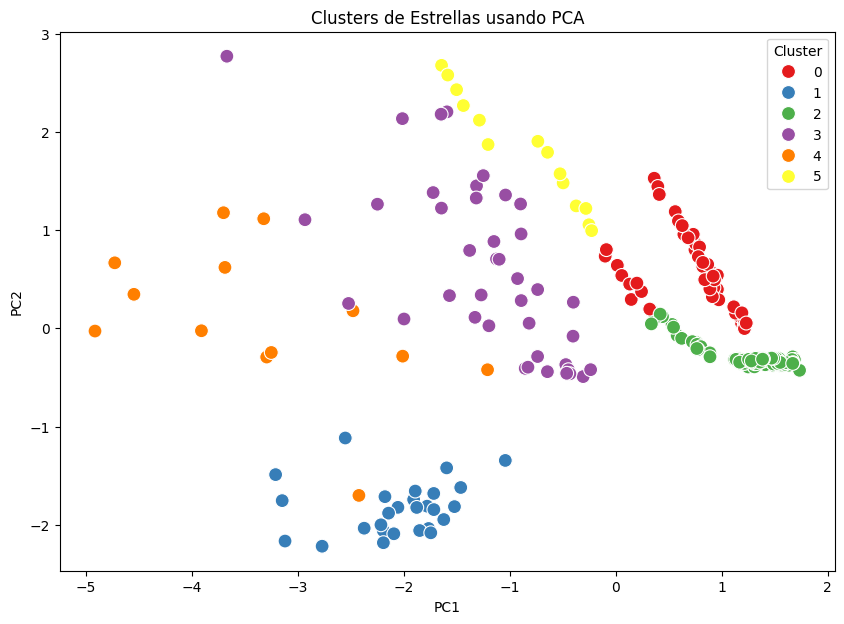

In [ ]:
# Aplicar PCA para reducir a 2 dimensiones:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Crear un DataFrame con los resultados de PCA:
pca_data = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_data['Cluster'] = data['Cluster']

# Graficar los clusters:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_data, palette='Set1', s=100)
plt.title('Clusters de Estrellas usando PCA')
plt.show()

### Características Promedio de Cada Cluster

Para entender mejor los clusters generados, podemos calcular las características promedio de las estrellas dentro de cada cluster.

In [ ]:
# Calcular las medias de las características originales por cluster:
cluster_means = data.groupby('Cluster')[features].mean()
cluster_means

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
Cluster,,,,
0,13869.306122,165.063211,1.158268,9.991082
1,4165.407407,255904.925926,1363.555556,-10.007407
2,3780.855670,2.264897,0.443148,12.974732
3,15347.850000,301816.250000,51.150000,-6.369925
4,26443.230769,420032.923077,1373.838462,-8.920769
5,28779.285714,91027.714286,6.873357,-3.955000


### Visualizar la Distribución de Características en Cada Cluster

Además de calcular los promedios de las características, podemos visualizar cómo se distribuyen las características dentro de cada cluster.

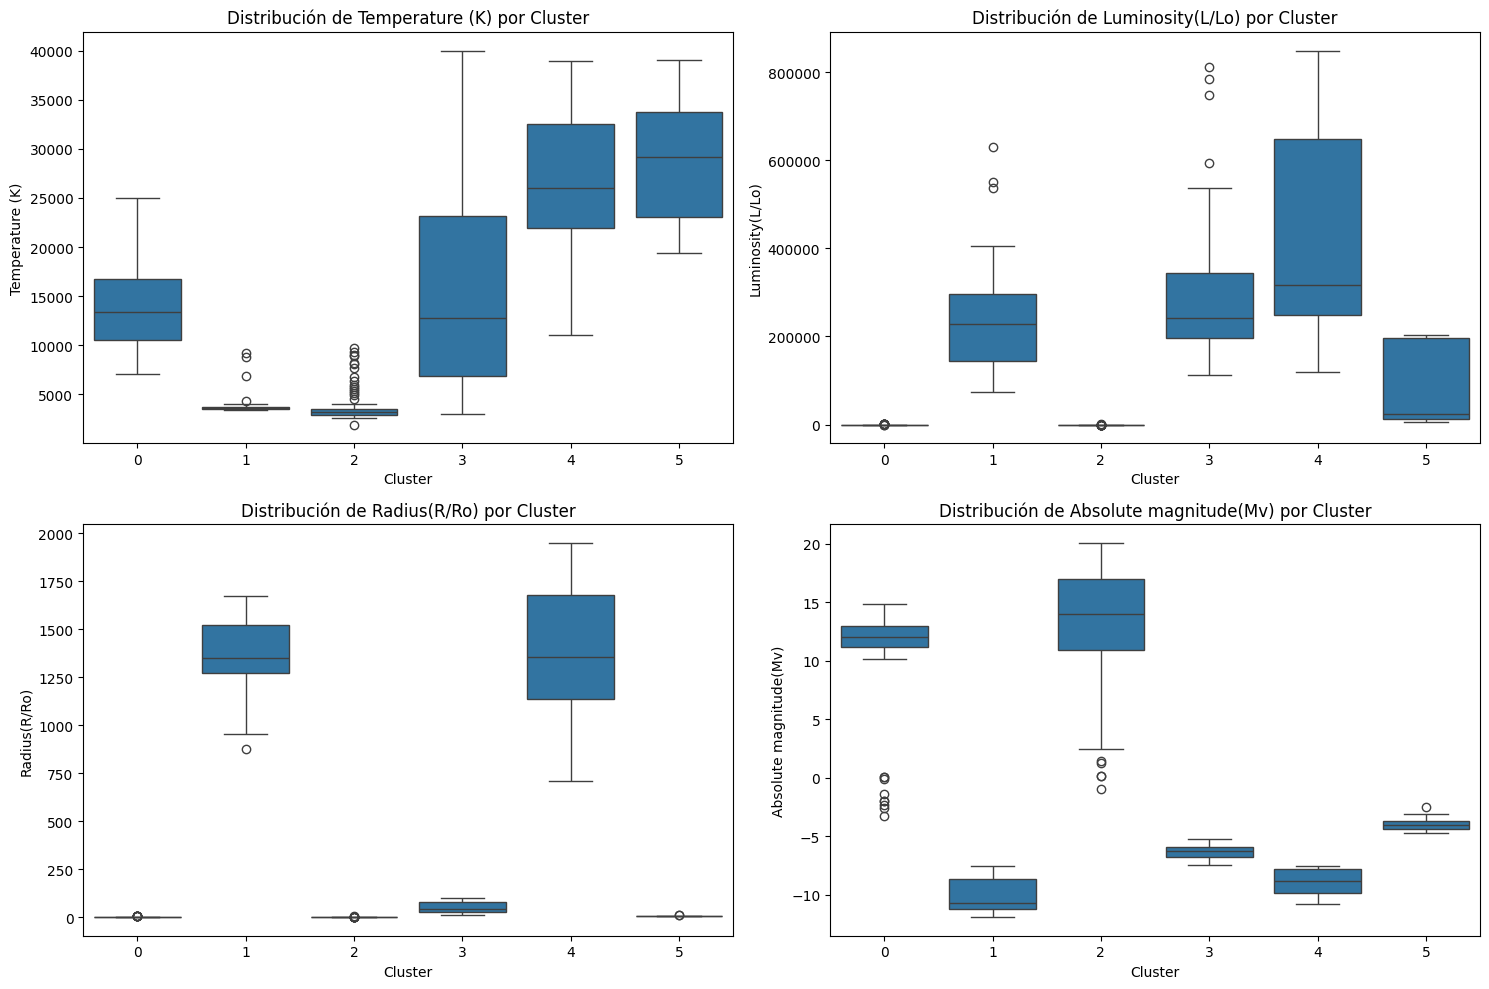

In [ ]:
# Visualizar la distribución de características para cada cluster:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='Cluster', y=feature, data=data)
    plt.title(f'Distribución de {feature} por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

### Comparar Clusters con Etiquetas Reales (`Star type`)
Tenemos etiquetas reales (`Star type`) en el dataset, por lo que podemos comparar los clusters generados con estas categorías para evaluar si coinciden.

In [ ]:
# Crear una tabla de contingencia entre los clusters y Star type:
cluster_analysis = data.groupby(['Cluster', 'Star type']).size().unstack(fill_value=0)
cluster_analysis

Star type,0,1,2,3,4,5
Cluster,,,,,,
0,0,0,40,9,0,0
1,0,0,0,0,0,27
2,40,40,0,17,0,0
3,0,0,0,0,40,0
4,0,0,0,0,0,13
5,0,0,0,14,0,0


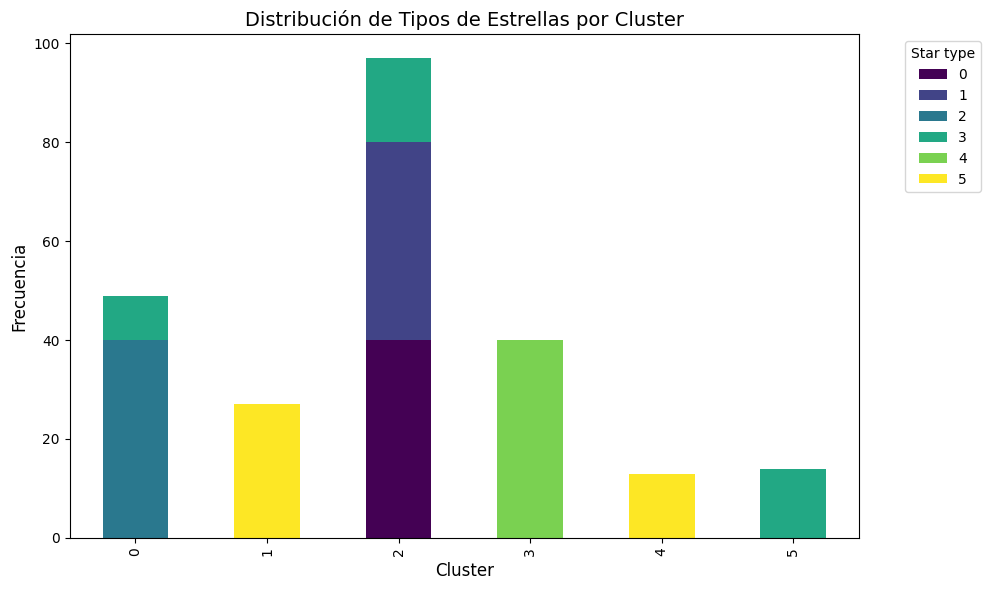

In [ ]:
# Crear un gráfico de barras apiladas:
cluster_analysis.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Personalizar el gráfico:
plt.title('Distribución de Tipos de Estrellas por Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend(title='Star type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Encontrar el Star type más frecuente para cada cluster
best_star_type_per_cluster = cluster_analysis.idxmax(axis=1)
print("Mejor Star type por cluster:")
print(best_star_type_per_cluster)

Mejor Star type por cluster:
Cluster
0    2
1    5
2    0
3    4
4    5
5    3
dtype: int64


In [ ]:
# Crear una columna con el Star type predicho
data['Predicted Star type'] = data['Cluster'].map(best_star_type_per_cluster)

# Calcular el número de aciertos
correct_predictions = (data['Star type'] == data['Predicted Star type']).sum()

# Calcular el porcentaje de aciertos
total_rows = len(data)
accuracy_percentage = (correct_predictions / total_rows) * 100

print(f"Número de aciertos: {correct_predictions}")
print(f"Porcentaje de aciertos: {accuracy_percentage:.2f}%")

Número de aciertos: 174
Porcentaje de aciertos: 72.50%


Links de prompts, bibliografía, etc:


1.   Generación de gráficos: https://chat.qwen.ai/s/f30dc397-1c98-4a85-9e3f-d8ca2ff023af
2.   Guía general: https://chatgpt.com/share/67e054f1-f75c-8010-aa0b-a0572a10cb6d


